In [15]:
%load_ext autoreload
%autoreload 2
from mmcontext.utils import setup_logging

logger = setup_logging()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from matplotlib import pyplot as plt


# ---------------------------------------------------------------------
# Helper: plot training loss from Trainer log history
# ---------------------------------------------------------------------
def plot_training_loss(trainer, title: str = "Training loss history"):
    """Extract 'loss' or 'train_loss' from Trainer.state.log_history and plot."""
    steps, vals = [], []
    for h in trainer.state.log_history:
        key = "loss" if "loss" in h else "train_loss" if "train_loss" in h else None
        if key:
            steps.append(h.get("step", len(steps)))
            vals.append(h[key])
    if not steps:
        logger.warning("No loss values found in Trainer log history – maybe increase `logging_steps`.")
        return
    plt.figure()
    plt.plot(steps, vals, marker="o")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [5]:
from datasets import load_dataset

dataset = load_dataset("jo-mengr/cellxgene_pseudo_bulk_35k_pairs_cell_type")

In [1]:
from mmcontext.mmcontextencoder import MMContextEncoder

enc = MMContextEncoder(
    "prajjwal1/bert-tiny",
    adapter_hidden_dim=None,
    adapter_output_dim=None,
    output_token_embeddings=False,
    freeze_text_encoder=True,
    train_lookup=False,
)
# token_df = enc.get_initial_embeddings(dataset, layer_key="X_geneformer", download_dir="../../data/from_nxtcloud")

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


In [7]:
# enc.register_initial_embeddings(token_df, data_origin="geneformer")
dataset_ready = enc.prefix_ds(dataset, cell_sentences_cols=["cell_sentence_1"])  # ,"negative_2"])

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
Prefixing cell_sentence_1: 100%|██████████| 5754/5754 [00:00<00:00, 949037.56 examples/s]


In [9]:
import numpy as np
from datasets import Dataset, DatasetDict


def fill_none(ds: Dataset | DatasetDict, placeholder: str = "unknown"):
    """
    Replace all None / NaN values in a Dataset or DatasetDict with *placeholder*.

    Returns a **new** object; the original is left unchanged.
    """

    def _clean_example(ex):
        for k, v in ex.items():
            if v is None or (isinstance(v, float) and np.isnan(v)):
                ex[k] = placeholder
        return ex

    if isinstance(ds, Dataset):
        return ds.map(_clean_example)
    else:  # DatasetDict – process every split
        return DatasetDict({name: split.map(_clean_example) for name, split in ds.items()})

In [10]:
dataset_ready = fill_none(dataset_ready)

Map: 100%|██████████| 5754/5754 [00:00<00:00, 62869.65 examples/s]


2025-05-26 16:11:12,832 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps


Step,Training Loss
1,0.249900
100,0.058800
200,0.030500
300,0.029400
400,0.027700


2025-05-26 16:11:33,949 - sentence_transformers.trainer - INFO - Saving model checkpoint to ./models/demo_sample_tokens/checkpoint-440
2025-05-26 16:11:33,949 - sentence_transformers.SentenceTransformer - INFO - Save model to ./models/demo_sample_tokens/checkpoint-440


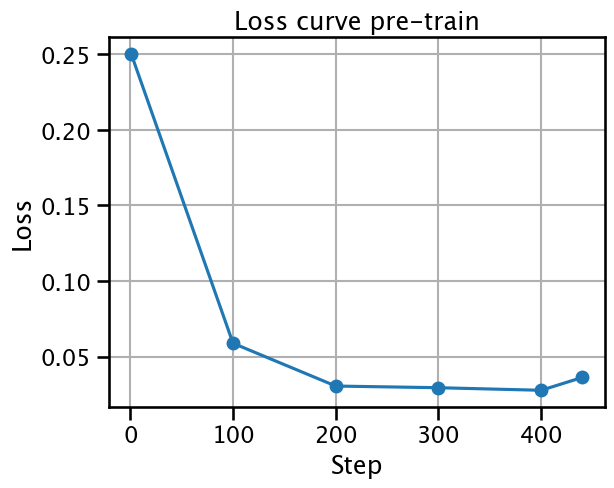

In [12]:
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)

train, val = dataset_ready["train"], dataset_ready["val"]
st = SentenceTransformer(modules=[enc])
out_dir = "./models/demo_sample_tokens"

loss = losses.ContrastiveLoss(model=st, margin=0.5)
# loss = losses.MultipleNegativesRankingLoss(model=st, scale = 0.2)
args = SentenceTransformerTrainingArguments(
    output_dir=out_dir,
    num_train_epochs=2,
    learning_rate=1e-2,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    logging_steps=100,
    logging_first_step=True,
    run_name="cell_types_35k",
)
trainer = SentenceTransformerTrainer(
    model=st,
    args=args,
    train_dataset=train,
    loss=loss,
)
trainer.train()
plot_training_loss(trainer, title="Loss curve pre-train")

# loss2 = losses.ContrastiveLoss(model=st, margin = 0.9)
# args2 = SentenceTransformerTrainingArguments(
#    output_dir=out_dir,
#    num_train_epochs=4,
#    learning_rate=1e-3,
#    per_device_train_batch_size=256,
#    per_device_eval_batch_size=256,
#    logging_steps=100,
#    logging_first_step=True,
#    run_name="cell_types_35k"
# )
# trainer2 = SentenceTransformerTrainer(
#    model =st,
#    args=args2,
#    train_dataset=train,
#    loss=loss2,
#    eval_dataset=val,
# )
# trainer2.train()
# plot_training_loss(trainer2, title="Loss curve fine-tune")

In [14]:
st.push_to_hub("cg_35k_contrastive_loss_cell_type_NeuML_pubmedbert-base-embeddings_geneformer")

2025-05-26 16:14:06,930 - sentence_transformers.SentenceTransformer - INFO - Save model to /var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/tmpw0a10gbf
model.safetensors: 100%|██████████| 17.7M/17.7M [00:01<00:00, 12.3MB/s]


'https://huggingface.co/jo-mengr/cg_35k_contrastive_loss_cell_type_NeuML_pubmedbert-base-embeddings_geneformer/commit/6860ee77bfa51a398fe46385601e5a499f51a1ac'

In [13]:
from mmcontext.file_utils import load_test_adata_from_hf_dataset, subset_dataset_by_chunk

adata, local_path = load_test_adata_from_hf_dataset(dataset["train"], save_dir="../../data/from_nxtcloud/train/sanity")
adata, train_sub = subset_dataset_by_chunk(adata, dataset["train"])

2025-05-26 16:11:45,908 - mmcontext.file_utils - INFO - Found 7 unique share links across ['test'] splits
2025-05-26 16:11:45,909 - mmcontext.file_utils - INFO - Picked share-link https://nxc-fredato.imbi.uni-freiburg.de/s/z8wFGmjxyogzKp5 (out of 7)
Download: 100%|██████████| 1/1 [00:10<00:00, 10.37s/file]
2025-05-26 16:11:56,791 - mmcontext.file_utils - INFO - Loaded test AnnData with 4572 cells × 13254 genes
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
2025-05-26 16:11:56,836 - mmcontext.file_utils - INFO - Subset HF dataset: kept 9144 / 56168 rows


In [13]:
if "label" in train_sub.column_names:
    # Filter out non-multiplet cells
    train_sub = train_sub.filter(lambda x: x["label"] == 1.0)

In [14]:
test_dataset = st[0].prefix_ds(train_sub, cell_sentences_cols=["cell_sentence_1"])

Prefixing cell_sentence_1: 100%|██████████| 4572/4572 [00:00<00:00, 76677.83 examples/s]


In [18]:
test_dataset

Dataset({
    features: ['sentence_1', 'sentence_2', 'label'],
    num_rows: 4572
})

In [22]:
if "sentence_1" in test_dataset.column_names:
    omics_embeddings = st.encode(test_dataset["sentence_1"])
if "anchor" in test_dataset.column_names:
    omics_embeddings = st.encode(test_dataset["anchor"])
if "sentence_2" in test_dataset.column_names:
    text_embeddings = st.encode(test_dataset["sentence_2"])
if "positive" in test_dataset.column_names:
    text_embeddings = st.encode(test_dataset["positive"])
adata.obsm["mmcontext_emb"] = omics_embeddings
adata.obsm["text_emb"] = text_embeddings

Batches: 100%|██████████| 143/143 [00:02<00:00, 50.99it/s]


2025-05-20 10:33:26,768 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-05-20 10:33:26,769 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='X_pca'.


<Figure size 800x800 with 0 Axes>

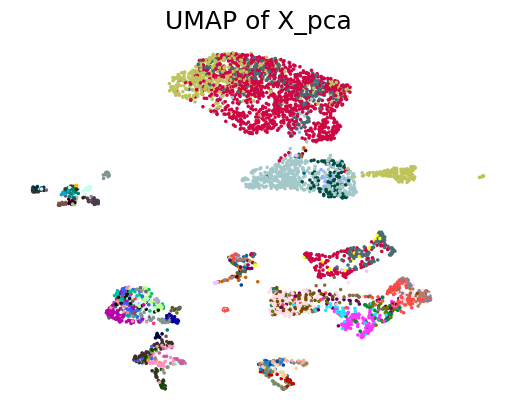

2025-05-20 10:33:37,150 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.
2025-05-20 10:33:37,152 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-05-20 10:33:37,152 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.


<Figure size 800x800 with 0 Axes>

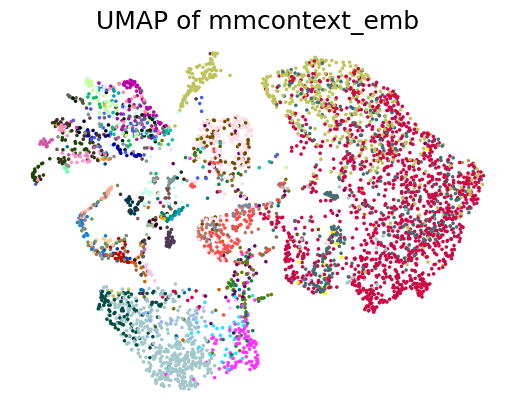

2025-05-20 10:33:40,573 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.
2025-05-20 10:33:40,574 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-05-20 10:33:40,574 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='text_emb'.


<Figure size 800x800 with 0 Axes>

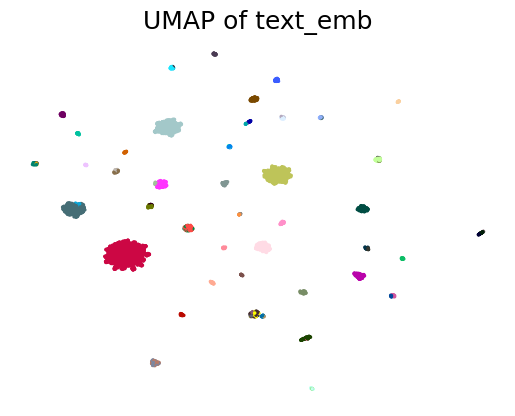

2025-05-20 10:33:48,978 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.
2025-05-20 10:33:48,978 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-05-20 10:33:48,979 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='X_pca'.


<Figure size 800x800 with 0 Axes>

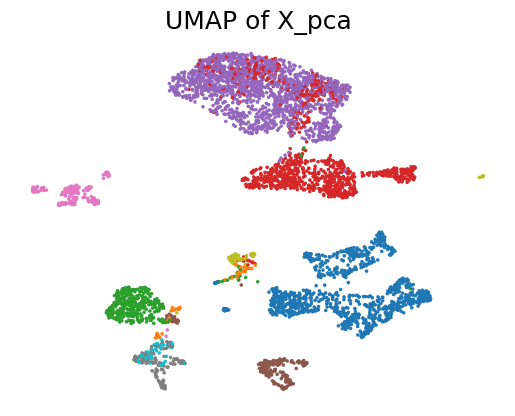

2025-05-20 10:33:52,586 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.
2025-05-20 10:33:52,587 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-05-20 10:33:52,587 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.


<Figure size 800x800 with 0 Axes>

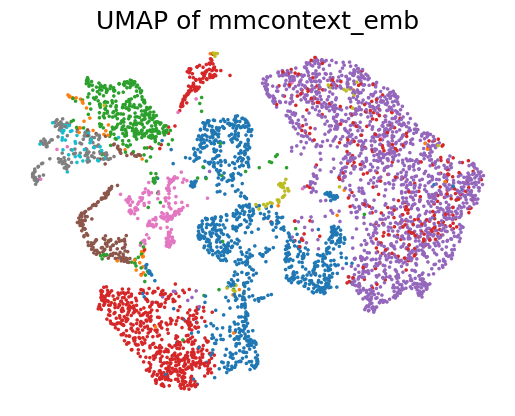

2025-05-20 10:33:56,054 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.
2025-05-20 10:33:56,055 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-05-20 10:33:56,055 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='text_emb'.


<Figure size 800x800 with 0 Axes>

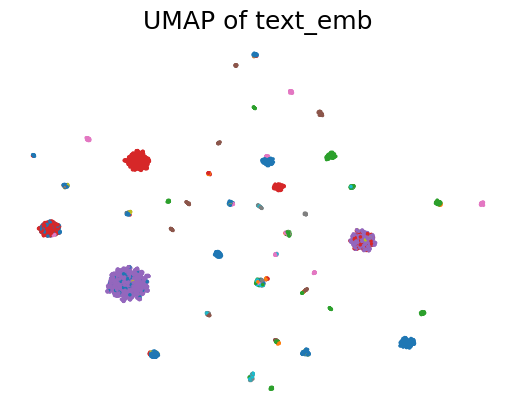

2025-05-20 10:34:04,695 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [23]:
from mmcontext.pl import plot_umap

# mmcontext imports
from mmcontext.utils import consolidate_low_frequency_categories

# LABEL_KEY = BATCH_KEY
adata_cut = adata.copy()
LABEL_KEYS = ["cell_type", "dataset_title"]
layers = ["X_pca", "mmcontext_emb", "text_emb"]
adata_cut = consolidate_low_frequency_categories(adata_cut, LABEL_KEYS, threshold=1, remove=True)

# The color_key can be changed to anything in adata.obs, e.g. BATCH_KEY or LABEL_KEY.
for color_key in LABEL_KEYS:
    for layer in layers:
        plot_umap(
            adata_cut,
            color_key=color_key,
            embedding_key=layer,
            legend_loc=None,
            save_plot=False,
            save_format="svg",
            save_dir=".",
        )